#### Necessary imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.layers import LSTM
from tensorflow.keras.layers import LSTM
from keras.layers import add
from keras.layers import Conv3D, MaxPooling3D
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#### Data Preprocessing

In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def process_images(row):
    cleaned_string = row.replace('[', '').replace(']', '').replace('\n', '') # Remove brackets and newlines
    float_array = np.array([float(x) for x in cleaned_string.split()]).reshape(7, 9) # Convert to a numpy array of floats and reshape
    return float_array

def data_preprocessing(n_future, x, y, yfilter):
    ydelta_O = y.diff(n_future)
    ydelta_F = yfilter.diff(n_future)
    data = pd.DataFrame([x, y, ydelta_O, yfilter, ydelta_F]).transpose()
    data.columns = ['rainfall', 'S.W.O', 'Δ S.W.O', 'S.W.F', 'Δ S.W.F']
    data = data[n_future:] # slicing and removing first n_future records
    return data

def reshapeImages(image, sequence_length) -> np.array:
    X = []
    image = np.array(image.tolist())
    for i in range(len(image)-sequence_length):
        X.append(image[i : i + sequence_length])
    X = np.asarray(X).astype(np.float32)
    X = X.reshape(X.shape[0], sequence_length, 7, 9)
    return np.array(X)

In [3]:
df = pd.read_csv('../data/sourcedata/Data.csv', index_col='Zeit')
df.index.name = None
df['Value'] = df['Value'].apply(process_images)
df.index = pd.to_datetime(df.index).strftime('%Y-%m-%d %H:%M')
df.head()

,GranetalsperreMin15Niederschlag,HahnenkleeMin15Niederschlag,MargarethenklippeMin15W,MargarethenklippeMin15Q,SennhuetteMin15W,SennhuetteMin15Q,Niederschlag_Gosequelle,Niederschlag_Abzuchtquelle,Pegel_Rammelsberghaus_Q,Pegel_Rammelsberghaus_W,Sensor_Sum,Value,Image_Sum
2003-11-01 00:00,0.0,0.0,6.9,0.033,4.6,0.034,0.0,0.0,0.082,10,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...",0.0
2003-11-01 00:15,0.0,0.0,7.3,0.038,4.4,0.032,0.0,0.0,0.076,10,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...",0.0
2003-11-01 00:30,0.0,0.0,7.3,0.038,4.3,0.031,0.0,0.0,0.074,10,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...",0.0
2003-11-01 00:45,0.0,0.0,7.2,0.037,4.4,0.032,0.0,0.0,0.076,10,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...",0.0
2003-11-01 01:00,0.0,0.0,7.2,0.037,4.5,0.033,0.0,0.0,0.079,10,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...",0.0


In [4]:
x = df['Value']
y = df['SennhuetteMin15W']
window = 8
yfilter = pd.Series(moving_average(y, window))
yfilter.index = y[:-(window-1)].index
n_past = 32 #8 hours into the past

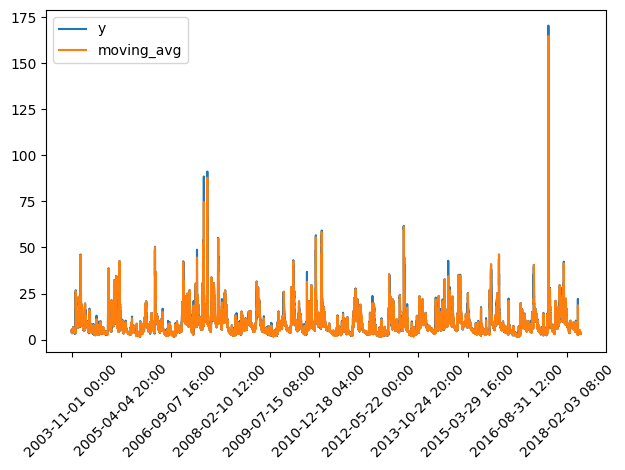

In [9]:
plt.plot(y.index, y, label='y')
plt.plot(yfilter.index, yfilter, label='moving_avg')
plt.xticks(y.index[::50000], rotation=45)
plt.tight_layout()
plt.legend();

#### Splitting dataset

In [5]:
def split_data(data, n, n_past):    
    n_train = int(len(data)*0.6) # Split into train and test datasets
    train = data[0:n_train]
    test = data[n_train:]
    
    train = train[train['Δ S.W.F'].abs() > 0.1] #remove imbalance from train dataset
    train.to_csv(f'../final results/STRPMr/Qualitative/{n}hrs/train_{n}h.csv')
    test.to_csv(f'../final results/STRPMr/Qualitative/{n}hrs/test_{n}h.csv')

    train_X = reshapeImages(train['rainfall'], n_past)
    test_X = reshapeImages(test['rainfall'], n_past)

    train_y = train['Δ S.W.F'][n_past:]
    test_y = test['Δ S.W.O'][n_past:]

    train_SW = train['S.W.F'][n_past:] # smoothened original S.W
    test_SW = test['S.W.O'][n_past:]
    test_SWF = test['S.W.F'][n_past:]

    print(f"Shape of X_train: {train_X.shape}, y_train: {train_y.shape}")
    print(f"Shape of X_test: {test_X.shape}, y_test: {test_y.shape}")
    print(f"Shape of train_SW, test_SW: {train_SW.shape, test_SW.shape}")

    return train_X, train_y, test_X, test_y, train_SW, test_SW, test_SWF

#### Plotting functions

In [6]:
def convert_to_dataframe(true, predicted, index, label1, label2, n): 
    df = pd.DataFrame([])
    df.index = index
    df[label1] = true
    df[label2] = predicted
    return df

def plot_pred(actual, pred, title, n):
    plt.plot(actual[172800:173300], label='actual')
    plt.plot(pred[172800:173300], label='predicted')
    plt.title(title)
    plt.xticks(actual.index[172800:173300][::100], rotation=45)
    plt.legend(loc='upper right')
    plt.savefig(f'../final results/STRPMr/Qualitative/{n}hrs/{title}.png')
    plt.show()
    
def plot_forecast(actual, forecast, start, end, index, label, title, n, plot):
    plt.rcParams["font.family"] = "cursive"
    plt.plot(index[start:end], actual[start:end], label='actual')
    plt.plot(index[start:end], forecast[start:end], label=label)
    #plt.plot(nochange[start:end], 'k--', label='no change')
    plt.title(title)
    plt.xticks(index[start:end][::100], rotation=45)
    plt.legend(loc='upper right')
    if plot==True:
        plt.savefig(f'../final results/STRPMr/Qualitative/{n}hrs/{title}.png')
    plt.show()

def plotTrainingLoss(history, n) -> None:
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.savefig(f'../final results/STRPMr/Qualitative/{n}hrs/trainingloss_{n}hrs.png')
    plt.show()

#### Special Convolutional model

In [7]:
def Conv2plus1d(input_shape):
    filters = 1
    kernel_size = [3,3,3]
    model = Sequential(name="specialconvmodel")
    model.add(Conv3D(filters, kernel_size=(1, kernel_size[1], kernel_size[2]), padding="same", activation='tanh', input_shape = input_shape))  # Spatial decomposition
    model.add(Conv3D(filters, kernel_size=(kernel_size[0], 1, 1), padding="same", activation="tanh")) # Temporal decomposition
    model.add(MaxPooling3D(pool_size=2, strides=2, padding="same"))
    
    model.add(Conv3D(3, kernel_size=(1, kernel_size[1], kernel_size[2]), padding="same", activation='tanh', input_shape = input_shape))  # Spatial decomposition
    model.add(Conv3D(3, kernel_size=(kernel_size[0], 1, 1), padding="same", activation="tanh")) # Temporal decomposition
    model.add(MaxPooling3D(pool_size=2, strides=2, padding="same"))
    model.add(Conv3D(6, kernel_size=(1, kernel_size[1], kernel_size[2]), padding="same", activation='tanh', input_shape = input_shape))  # Spatial decomposition
    model.add(Conv3D(6, kernel_size=(kernel_size[0], 1, 1), padding="same", activation="tanh")) # Temporal decomposition   
    return model


def neuralnetwork(X_train, y_train, n):
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)
    y_train = (np.asarray(y_train).astype(np.float32)).reshape(-1,1)
    
    model = Conv2plus1d(input_shape)
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(8))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units = 1, activation = 'linear')) 
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    model.build()
    model.summary()
    history = model.fit(X_train, y_train, epochs=30, batch_size=256, validation_split=0.20) 
    plotTrainingLoss(history, n)
    model.save(f'../final results/STRPMr/Qualitative/{n}hrs/model_{n}hrs.h5')
    return model

#### Forecasting framework

In [8]:
def evaluatemodel(model, test_x, test_y, n):
    model.evaluate(test_x, (np.asarray(test_y).astype(np.float32)).reshape(-1,1), return_dict=True)
    y_pred = model.predict(test_x)
    prediction = convert_to_dataframe(test_y, y_pred, test_y.index, 'ytrue', 'ypred', n)
    prediction.to_csv(f'../final results/STRPMr/Qualitative/{n}hrs/predictions_{n}h.csv') 
    plot_pred(prediction['ytrue'], prediction['ypred'], f'{n}hrs- test predictions(Δs)', n)
    return prediction

In [9]:
def forecastingmodel(prediction, n_future, actual_water_levels, n, start, end, plot=False):

    nochange = actual_water_levels[0:-n_future].values
    forecast = actual_water_levels[0:-n_future].values + prediction['ypred'][n_future:].values
    actual_water_levels = actual_water_levels[n_future:]
    index = actual_water_levels.index
    actual_water_levels = actual_water_levels.values
    #forecast = actual_water_levels.shift(-n_future) + prediction['ypred']
    #forecast = forecast.shift(n_future)
    
    plot_forecast(actual_water_levels, forecast, start, end, index, f'{n}h forecast', f'{n}-hrs forecast', n, plot)
    if plot==True:
        forecast_df = convert_to_dataframe(actual_water_levels, forecast, index, 'measured', 'predicted', n)
        baseline_df = convert_to_dataframe(actual_water_levels, nochange, index, 'measured', 'predicted', n)
        forecast_df.to_csv(f'../final results/STRPMr/Qualitative/{n}hrs/forecasts_{n}h.csv') 
        baseline_df.to_csv(f'../final results/Baseline/Qualitative/{n}hrs/forecasts_{n}h.csv') 
    return forecast, actual_water_levels, nochange

#### 2-hours forecast

In [10]:
n_future =  8
data2 = data_preprocessing(n_future, x, y, yfilter)
train_X2, train_y2, test_X2, test_y2, train_SW2, test_SW2, test_SWF2 = split_data(data2, int(n_future/4), n_past)

Shape of X_train: (117512, 32, 7, 9), y_train: (117512,)
Shape of X_test: (205636, 32, 7, 9), y_test: (205636,)
Shape of train_SW, test_SW: ((117512,), (205636,))


In [12]:
data2['Δ S.W.F'].min(), data2['Δ S.W.F'].max(), data2['Δ S.W.O'].min(), data2['Δ S.W.O'].max()

(-32.42500000000001, 54.03750000000001, -42.199999999999996, 64.4)



Model: "specialconvmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 32, 7, 9, 1)       10        
                                                                 
 conv3d_1 (Conv3D)           (None, 32, 7, 9, 1)       4         
                                                                 
 max_pooling3d (MaxPooling3  (None, 16, 4, 5, 1)       0         
 D)                                                              
                                                                 
 conv3d_2 (Conv3D)           (None, 16, 4, 5, 3)       30        
                                                                 
 conv3d_3 (Conv3D)           (None, 16, 4, 5, 3)       30        
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 8, 2, 3, 3)        0         
 g3D)                                           

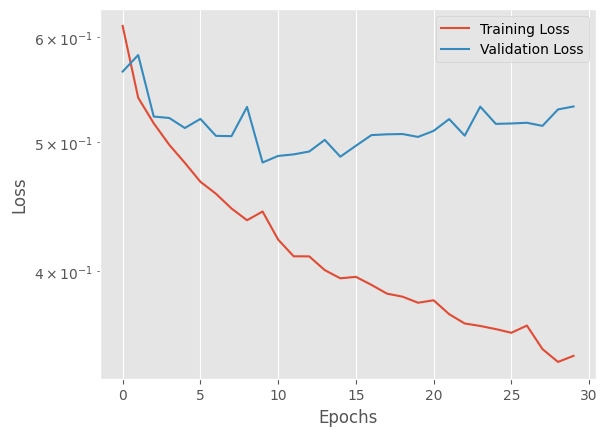

c:\Users\ss97\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
model2 = neuralnetwork(train_X2, train_y2, int(n_future/4)) #train with 2plus1D CNN-LSTM model

6427/6427 [==============================] - 26s 4ms/step


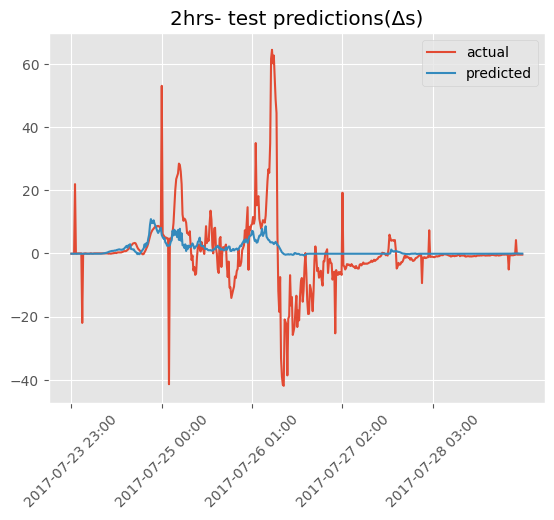

In [14]:
predictions2 = evaluatemodel(model2, test_X2, test_y2, int(n_future/4)) #predictions

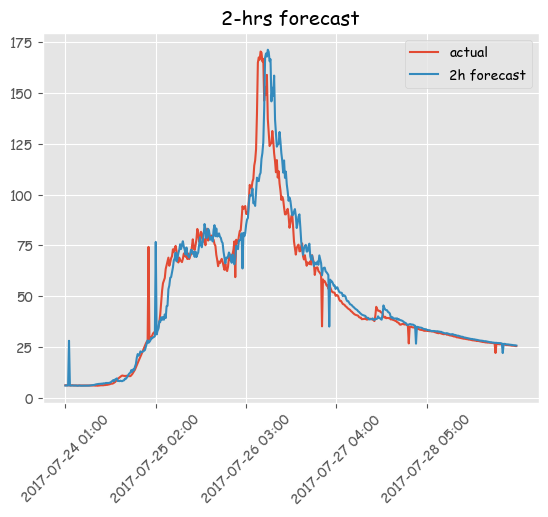

In [15]:
forecast2, actual_water_levels2, nochange2 = forecastingmodel(predictions2, 8, test_SW2, 2, 172800, 173300, True) #evaluate model

In [16]:
mse_baseline_2 = np.round(mean_squared_error(actual_water_levels2, nochange2),4)
mse_2 = np.round(mean_squared_error(actual_water_levels2, forecast2),4)
print("MSE Baseline: (2hrs)", mse_baseline_2)
print("MSE STRPMr: (2hrs)", mse_2)

MSE Baseline: (2hrs) 0.7306
MSE STRPMr: (2hrs) 0.7186


#### 3-hours forecast

In [17]:
n_future =  12
data3 = data_preprocessing(n_future, x, y, yfilter)
train_X3, train_y3, test_X3, test_y3, train_SW3, test_SW3, test_SWF3 = split_data(data3, int(n_future/4), n_past)

Shape of X_train: (144402, 32, 7, 9), y_train: (144402,)
Shape of X_test: (205634, 32, 7, 9), y_test: (205634,)
Shape of train_SW, test_SW: ((144402,), (205634,))


Model: "specialconvmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 32, 7, 9, 1)       10        
                                                                 
 conv3d_7 (Conv3D)           (None, 32, 7, 9, 1)       4         
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 16, 4, 5, 1)       0         
 g3D)                                                            
                                                                 
 conv3d_8 (Conv3D)           (None, 16, 4, 5, 3)       30        
                                                                 
 conv3d_9 (Conv3D)           (None, 16, 4, 5, 3)       30        
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 8, 2, 3, 3)        0         
 g3D)                                             

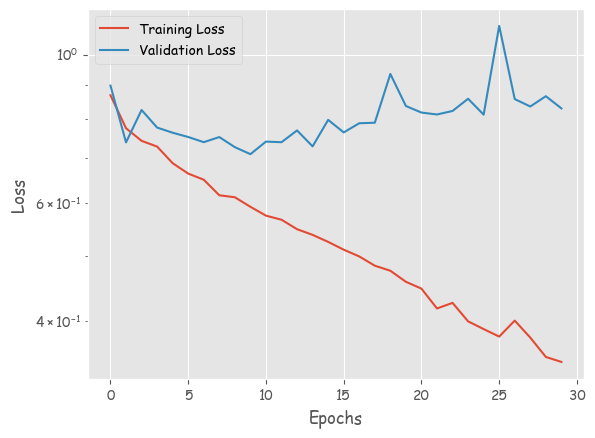

c:\Users\ss97\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
model3 = neuralnetwork(train_X3, train_y3, int(n_future/4)) #train model

6427/6427 [==============================] - 28s 4ms/step


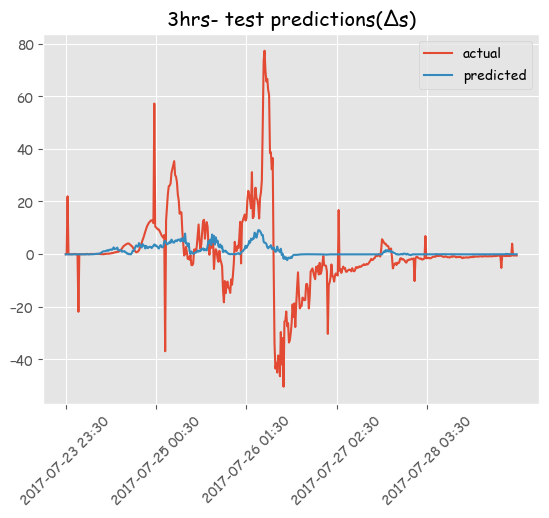

In [19]:
predictions3 = evaluatemodel(model3, test_X3, test_y3, int(n_future/4)) #predictions

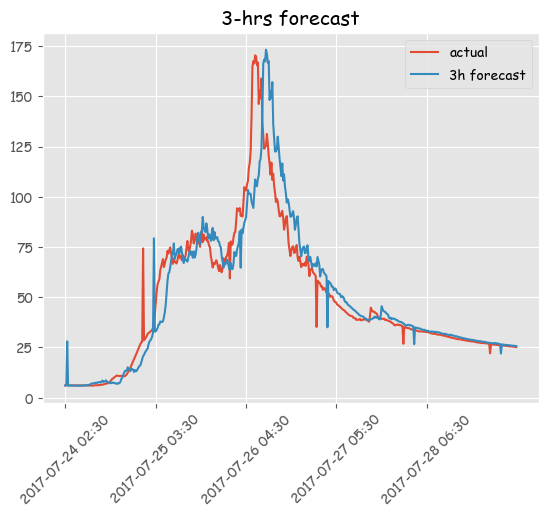

In [20]:
forecast3, actual_water_levels3, nochange3 = forecastingmodel(predictions3, 12, test_SW3, 3, 172800, 173300, True) #evaluate model

In [21]:
mse_baseline_3 = np.round(mean_squared_error(actual_water_levels3, nochange3),4)
mse_3 = np.round(mean_squared_error(actual_water_levels3, forecast3),4)
print("MSE Baseline (3hrs): ", mse_baseline_3)
print("MSE STRPMr (3hrs): ", mse_3)

MSE Baseline (3hrs):  1.1261
MSE STRPMr (3hrs):  1.0592


#### 4 hours

In [52]:
n_future = 16
data4 = data_preprocessing(n_future, x, y, yfilter)
train_X4, train_y4, test_X4, test_y4, train_SW4, test_SW4, test_SWF4 = split_data(data4, int(n_future/4), n_past)

KeyboardInterrupt: 

Model: "specialconvmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 32, 7, 9, 1)       10        
                                                                 
 conv3d_13 (Conv3D)          (None, 32, 7, 9, 1)       4         
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 16, 4, 5, 1)       0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 16, 4, 5, 3)       30        
                                                                 
 conv3d_15 (Conv3D)          (None, 16, 4, 5, 3)       30        
                                                                 
 max_pooling3d_5 (MaxPoolin  (None, 8, 2, 3, 3)        0         
 g3D)                                             

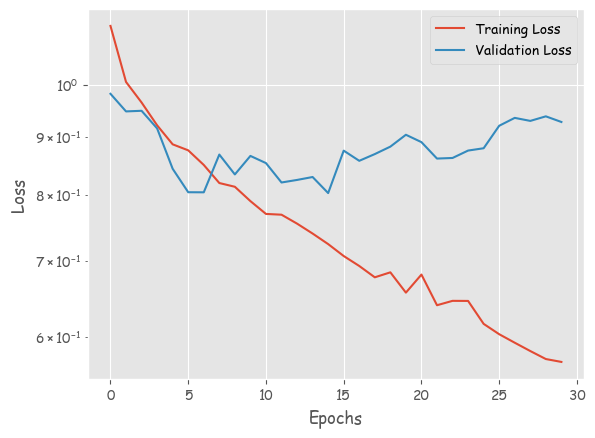

c:\Users\ss97\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model4 = neuralnetwork(train_X4, train_y4, int(n_future/4)) #train model

6426/6426 [==============================] - 28s 4ms/step


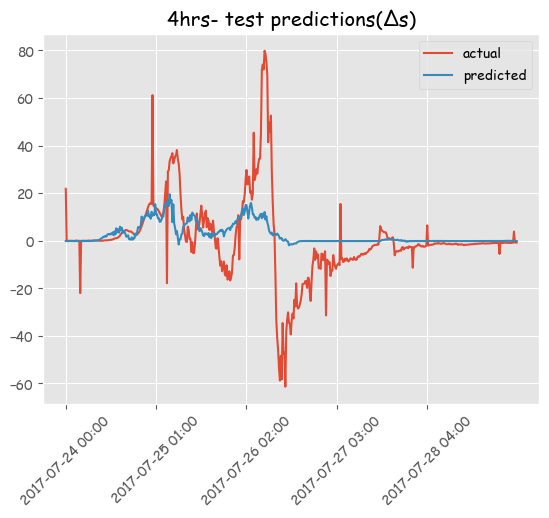

In [ ]:
predictions4 = evaluatemodel(model4, test_X4, test_y4, int(n_future/4)) #predictions

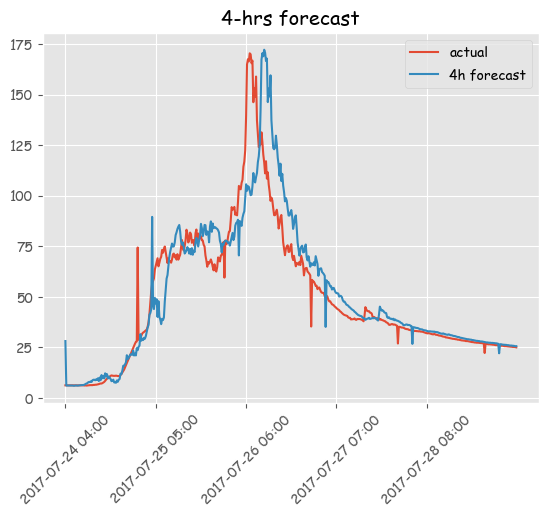

In [ ]:
forecast4, actual_water_levels4, nochange4 = forecastingmodel(predictions4, 16, test_SW4, 4, 172800, 173300, True) #evaluate model

In [ ]:
mse_baseline_4 = np.round(mean_squared_error(actual_water_levels4, nochange4),4)
mse_4 = np.round(mean_squared_error(actual_water_levels4, forecast4),4)
print("MSE Baseline (4hrs): ", mse_baseline_4)
print("MSE STRPMr (4hrs): ", mse_4)

MSE Baseline (4hrs):  1.523
MSE STRPMr (4hrs):  1.3548


#### 8 hours

In [27]:
n_future = 32
data8 = data_preprocessing(n_future, x, y, yfilter)
train_X8, train_y8, test_X8, test_y8, train_SW8, test_SW8, test_SWF8 = split_data(data8, int(n_future/4), n_past)

Shape of X_train: (207843, 32, 7, 9), y_train: (207843,)
Shape of X_test: (205626, 32, 7, 9), y_test: (205626,)
Shape of train_SW, test_SW: ((207843,), (205626,))


Model: "specialconvmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 32, 7, 9, 1)       10        
                                                                 
 conv3d_19 (Conv3D)          (None, 32, 7, 9, 1)       4         
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 16, 4, 5, 1)       0         
 g3D)                                                            
                                                                 
 conv3d_20 (Conv3D)          (None, 16, 4, 5, 3)       30        
                                                                 
 conv3d_21 (Conv3D)          (None, 16, 4, 5, 3)       30        
                                                                 
 max_pooling3d_7 (MaxPoolin  (None, 8, 2, 3, 3)        0         
 g3D)                                             

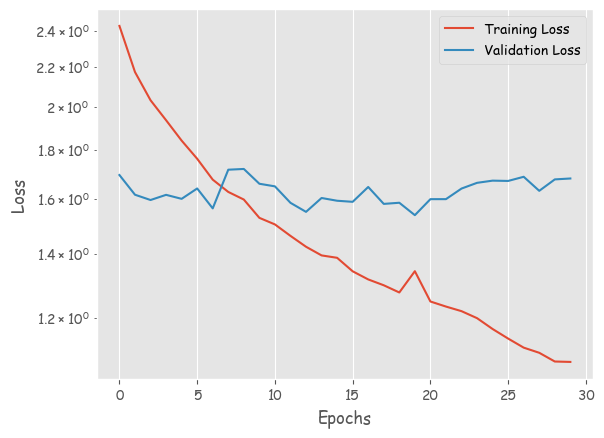

c:\Users\ss97\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
model8 = neuralnetwork(train_X8, train_y8, int(n_future/4)) #train model

6426/6426 [==============================] - 28s 4ms/step


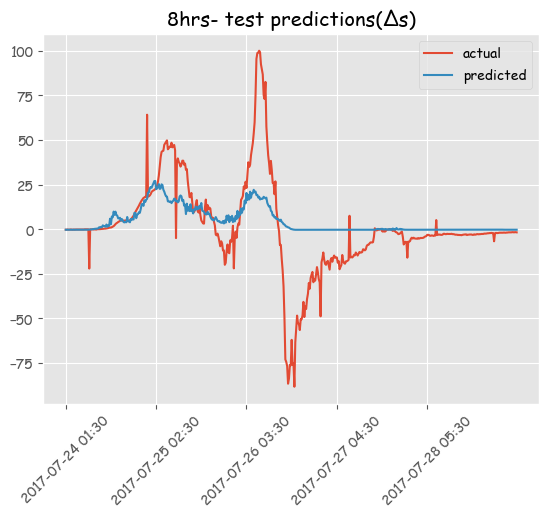

In [29]:
predictions8 = evaluatemodel(model8, test_X8, test_y8, 8) #predictions

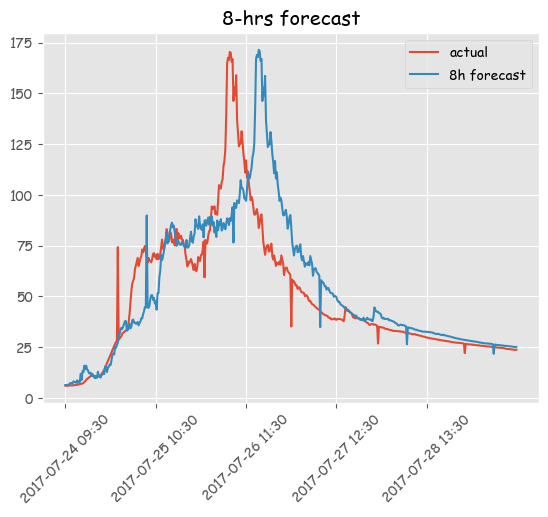

In [47]:
forecast8, actual_water_levels8, nochange8 = forecastingmodel(predictions8, 32, test_SW8, 8, 172800, 173300, True) #evaluate model

In [31]:
mse_baseline_8 = np.round(mean_squared_error(actual_water_levels8, nochange8),4)
mse_8 = np.round(mean_squared_error(actual_water_levels8, forecast8),4)
print("MSE Baseline (8hrs): ", mse_baseline_8)
print("MSE STRPMr (8hrs): ", mse_8)

MSE Baseline (8hrs):  3.2955
MSE STRPMr (8hrs):  2.8206


#### 12-hours

In [32]:
n_future = 48
data12 = data_preprocessing(n_future, x, y, yfilter)
train_X12, train_y12, test_X12, test_y12, train_SW12, test_SW12, test_SWF12 = split_data(data12, int(n_future/4), n_past)

Shape of X_train: (227121, 32, 7, 9), y_train: (227121,)
Shape of X_test: (205620, 32, 7, 9), y_test: (205620,)
Shape of train_SW, test_SW: ((227121,), (205620,))


Model: "specialconvmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 32, 7, 9, 1)       10        
                                                                 
 conv3d_25 (Conv3D)          (None, 32, 7, 9, 1)       4         
                                                                 
 max_pooling3d_8 (MaxPoolin  (None, 16, 4, 5, 1)       0         
 g3D)                                                            
                                                                 
 conv3d_26 (Conv3D)          (None, 16, 4, 5, 3)       30        
                                                                 
 conv3d_27 (Conv3D)          (None, 16, 4, 5, 3)       30        
                                                                 
 max_pooling3d_9 (MaxPoolin  (None, 8, 2, 3, 3)        0         
 g3D)                                             

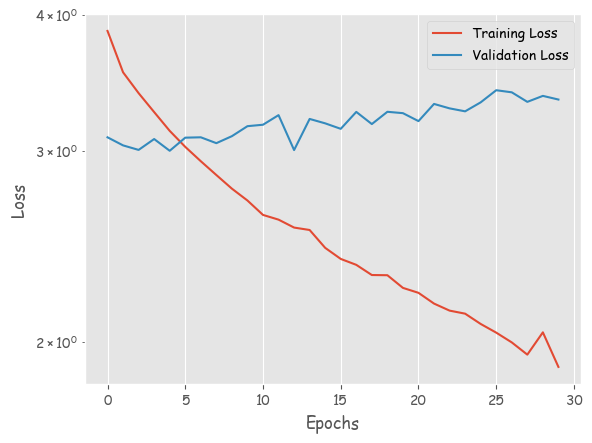

c:\Users\ss97\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
model12 = neuralnetwork(train_X12, train_y12, int(n_future/4)) #train model

6426/6426 [==============================] - 37s 6ms/step


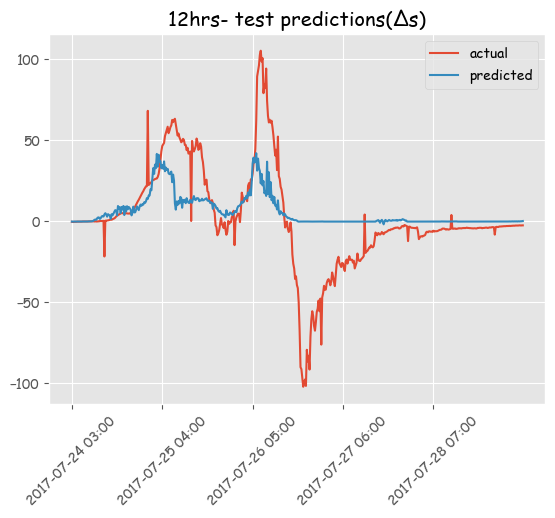

In [34]:
predictions12 = evaluatemodel(model12, test_X12, test_y12, int(n_future/4)) #predictions

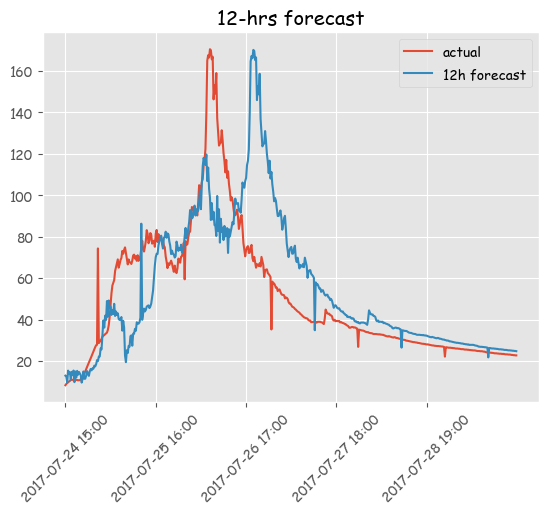

In [35]:
forecast12, actual_water_levels12, nochange12 = forecastingmodel(predictions12, 48, test_SW12, 12, 172800, 173300, True) #evaluate model

In [36]:
mse_baseline_12 = np.round(mean_squared_error(actual_water_levels12, nochange12),4)
mse_12 = np.round(mean_squared_error(actual_water_levels12, forecast12),4)
print("MSE Baseline (12hrs): ", mse_baseline_12)
print("MSE STRPMr (12hrs): ", mse_12)

MSE Baseline (12hrs):  5.0322
MSE STRPMr (12hrs):  3.8509


#### Plot all forecasts

In [37]:
def forecast_plot(actual, pred, nochange, ax, n, start, end, type=True):#, colors):
    if type==False:
        label = 'pred'
        ylabel = 'Δ S.W'
        if n==8 or n==12:
            ax.set_xlabel('Date')
    else:
        label= 'forecast'
        ylabel = 'S.W'
        if n==8 or n==12:
            ax.set_xlabel('Timesteps')

    if n==2 or n==8:
        ax.set_ylabel(ylabel)

    ax.plot(actual[start:end], label='actual')
    if type==True:
        ax.plot(nochange[start:end], 'k--', label='no change')
    ax.plot(pred[start:end], label=label)
    ax.title.set_text(f'{n}-hrs')
    ax.tick_params(labelrotation=45)
    #ax.legend(loc='upper left')

<Figure size 640x480 with 0 Axes>

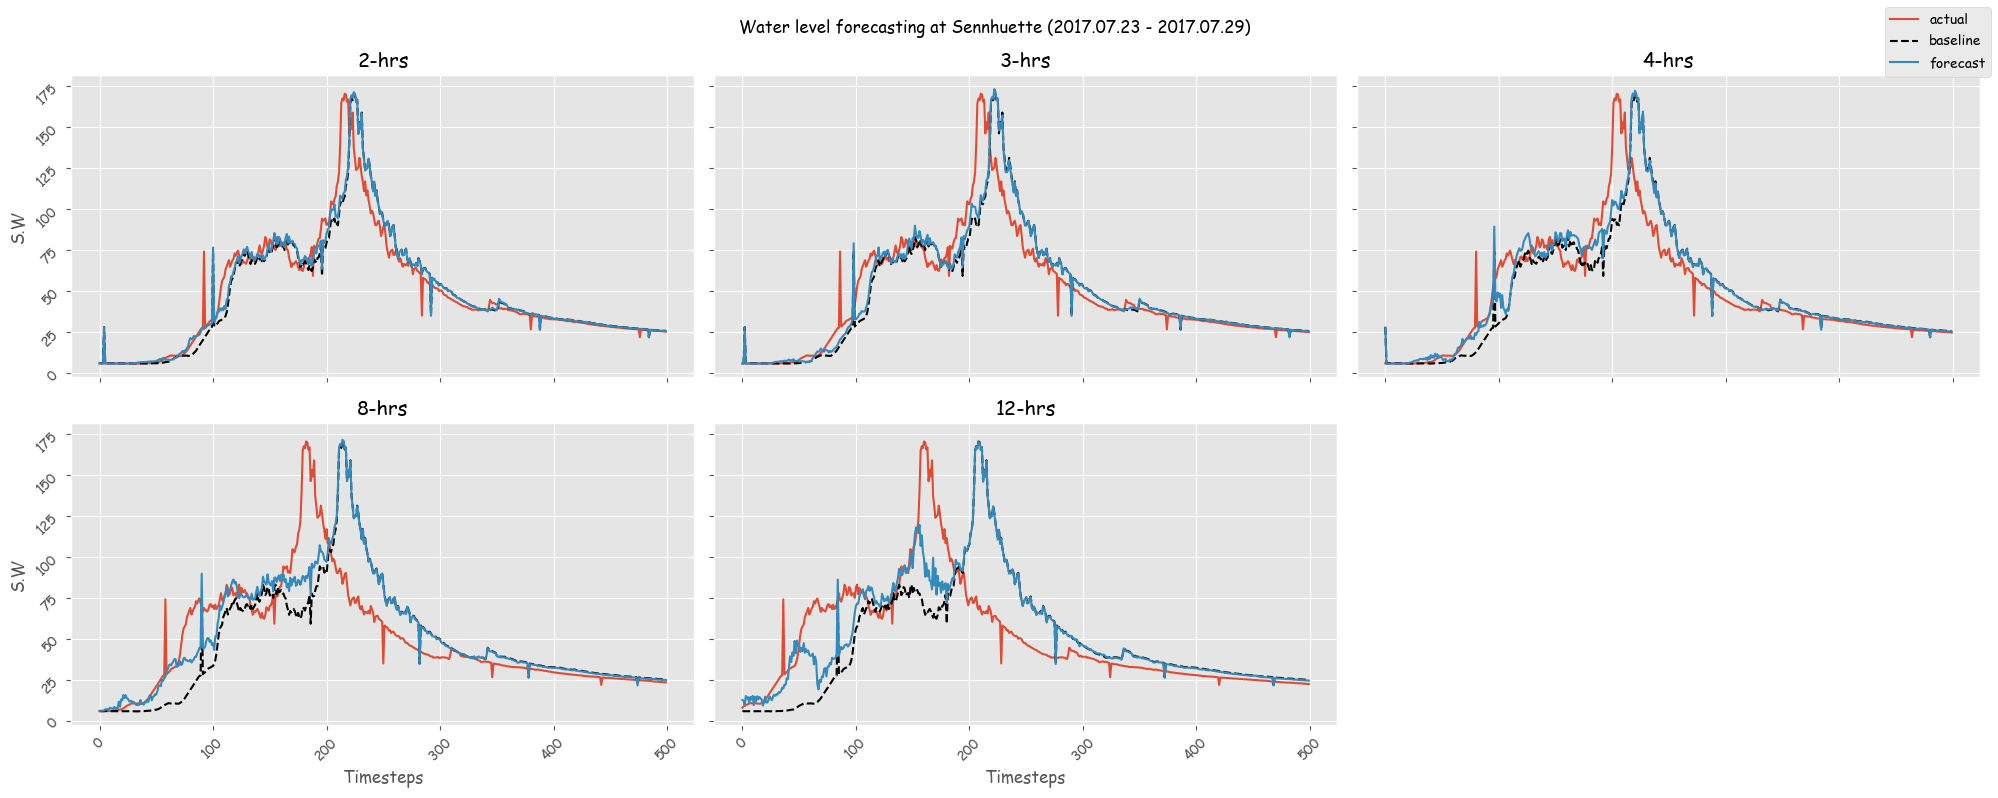

In [51]:
f = plt.figure()    
f, axes = plt.subplots(nrows = 2, ncols = 3, sharex=True, sharey = True)
f.set_size_inches(20, 8)
title = 'Water level forecasting at Sennhuette (2017.07.23 - 2017.07.29)'
plt.suptitle(title)
forecast_plot(actual_water_levels2, forecast2, nochange2, axes[0][0], 2, 172800, 173300)
forecast_plot(actual_water_levels3, forecast3, nochange3, axes[0][1], 3, 172800, 173300)
forecast_plot(actual_water_levels4, forecast4, nochange4, axes[0][2], 4, 172800, 173300)
forecast_plot(actual_water_levels8, forecast8, nochange8, axes[1][0], 8, 172800, 173300)
forecast_plot(actual_water_levels12, forecast12, nochange12, axes[1][1], 12, 172800, 173300)
labels = ['actual', 'baseline', 'forecast']
f.legend(labels, bbox_transform = plt.gcf().transFigure)
axes[-1, -1].axis('off')
plt.tight_layout()
plt.savefig(f'../final results/STRPMr/Qualitative/{title}.png')

In [40]:
def forecast_plot_sameaxis(actual, pred, ax, n, start, end, type=True):#, colors):
    if type==False:
        label = 'pred'
        ylabel = 'Δ S.W'
    else:
        label= 'forecast'
        ylabel = 'S.W'

    if n==2 or n==3 or n==4 or n==8 or n==12: #set ylabel for all intervals
        ax.set_ylabel(ylabel)
    if n==2 or n==3 or n==4 or n==8: #turn off xticks expect last graph n=12
        ax.set_xticklabels([])
    ax.tick_params(labelrotation=45) 

    if n==12:
        ax.set_xlabel('Timesteps')
        
    ax.plot(actual[start:end], label='actual') #plot
    ax.plot(pred[start:end], label=label)
    ax.title.set_text(f'{n}-hrs') #set title
    
    if n==2: #only legend on one subgraph
        ax.legend(loc='upper left')

<Figure size 640x480 with 0 Axes>

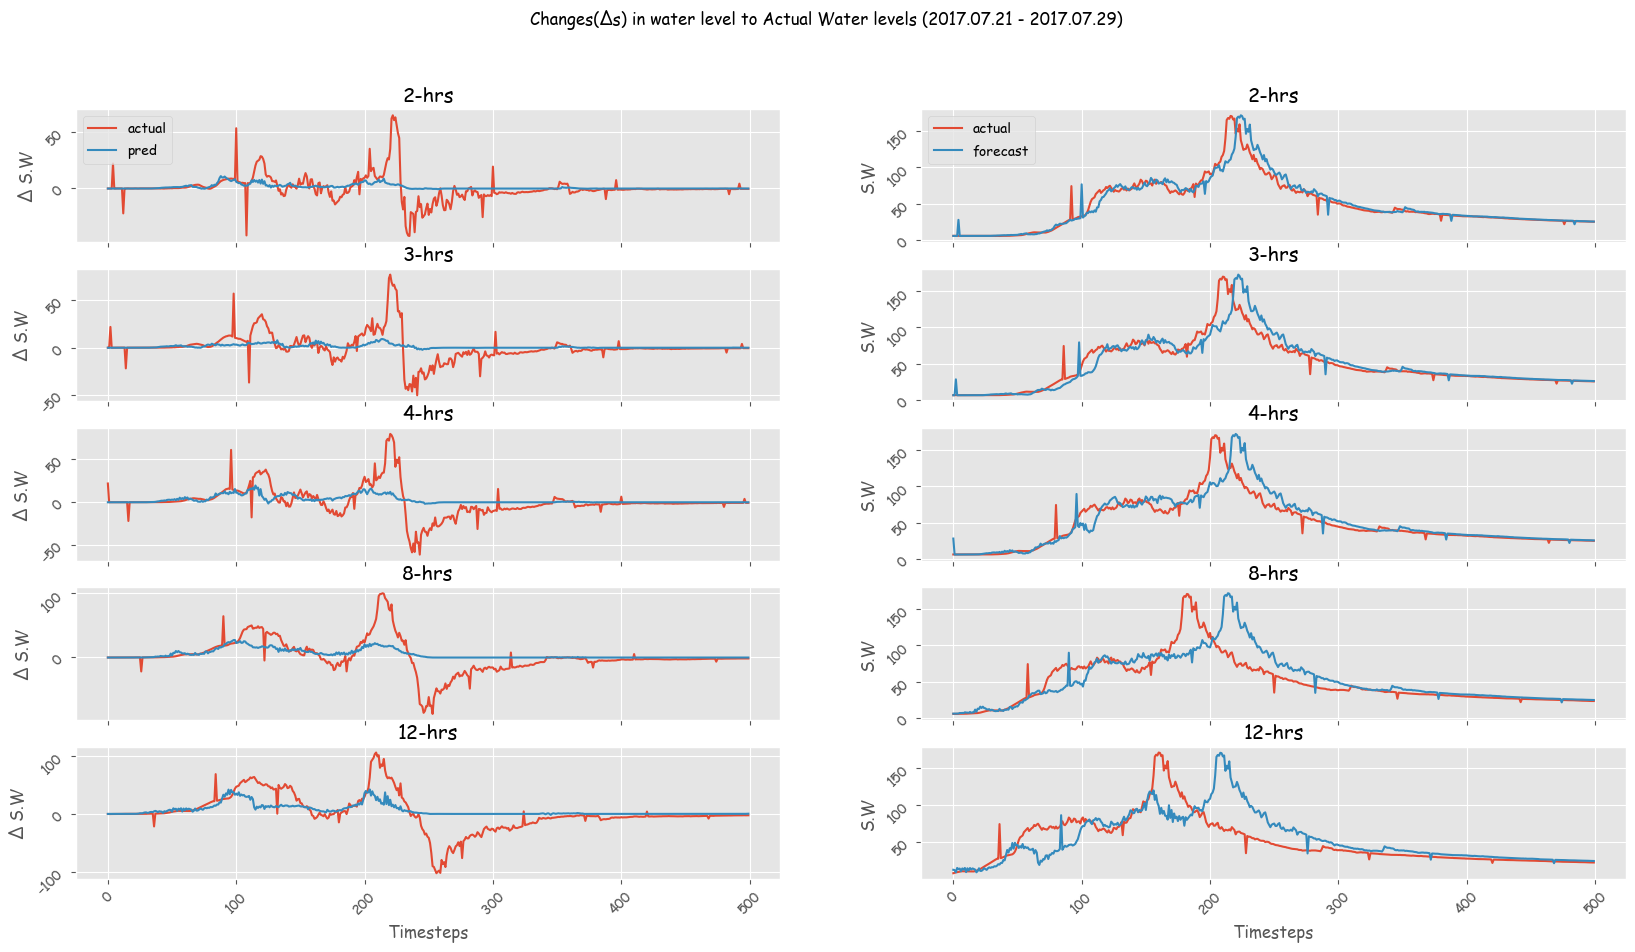

In [41]:
f = plt.figure()    
f, axes = plt.subplots(nrows = 5, ncols = 2, sharex=False, sharey = False)
f.set_size_inches(20, 10)
title = 'Changes(Δs) in water level to Actual Water levels (2017.07.21 - 2017.07.29)'
plt.suptitle(title)
forecast_plot_sameaxis(predictions2['ytrue'].values, predictions2['ypred'].values, axes[0][0], 2, 172800, 173300, False)
forecast_plot_sameaxis(actual_water_levels2, forecast2, axes[0][1], 2, 172800, 173300)

forecast_plot_sameaxis(predictions3['ytrue'].values, predictions3['ypred'].values, axes[1][0], 3, 172800, 173300, False)
forecast_plot_sameaxis(actual_water_levels3, forecast3, axes[1][1], 3, 172800, 173300)

forecast_plot_sameaxis(predictions4['ytrue'].values, predictions4['ypred'].values, axes[2][0], 4, 172800, 173300, False)
forecast_plot_sameaxis(actual_water_levels4, forecast4, axes[2][1], 4, 172800, 173300)

forecast_plot_sameaxis(predictions8['ytrue'].values, predictions8['ypred'].values, axes[3][0], 8, 172800, 173300, False)
forecast_plot_sameaxis(actual_water_levels8, forecast8, axes[3][1], 8, 172800, 173300)

forecast_plot_sameaxis(predictions12['ytrue'].values, predictions12['ypred'].values, axes[4][0], 12, 172800, 173300, False)
forecast_plot_sameaxis(actual_water_levels12, forecast12, axes[4][1], 12, 172800, 173300)

plt.savefig(f'../final results/STRPMr/Qualitative/{title}.png')
plt.show()

#### Compare all

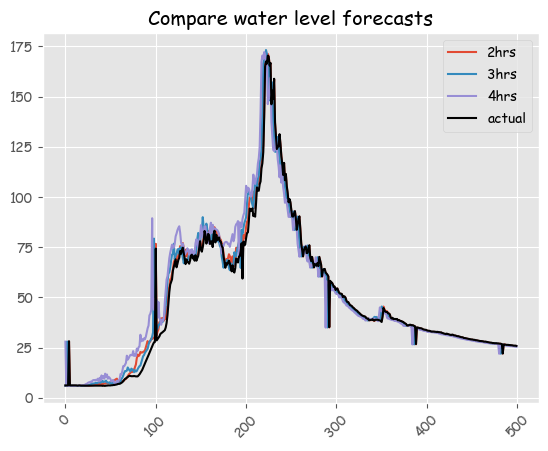

In [42]:
plt.plot(forecast2[172800:173300], label='2hrs')
plt.plot(forecast3[172800:173300], label='3hrs')
plt.plot(forecast4[172800:173300], label='4hrs')
plt.plot(test_SW2[172800:173300].values, color='black', label='actual')
plt.xticks(rotation=45)
plt.title('Compare water level forecasts')
plt.legend();

#### MSE

In [43]:
mse_baseline_2 = np.round(mean_squared_error(actual_water_levels2, nochange2),4)
mse_baseline_3 = np.round(mean_squared_error(actual_water_levels3, nochange3),4)
mse_baseline_4 = np.round(mean_squared_error(actual_water_levels4, nochange4),4)
mse_baseline_8 = np.round(mean_squared_error(actual_water_levels8, nochange8),4)
mse_baseline_12 = np.round(mean_squared_error(actual_water_levels12, nochange12),4)

In [44]:
mse_2 = np.round(mean_squared_error(actual_water_levels2, forecast2),4)
mse_3 = np.round(mean_squared_error(actual_water_levels3, forecast3),4)
mse_4 = np.round(mean_squared_error(actual_water_levels4, forecast4),4)
mse_8 = np.round(mean_squared_error(actual_water_levels8, forecast8),4)
mse_12 = np.round(mean_squared_error(actual_water_levels12, forecast12),4)

##### Baseline MSE

In [45]:
mse_baseline_2, mse_baseline_3, mse_baseline_4, mse_baseline_8, mse_baseline_12

(0.7306, 1.1261, 1.523, 3.2955, 5.0322)

##### STRPMr MSE

In [46]:
mse_2, mse_3, mse_4, mse_8, mse_12

(0.7186, 1.0592, 1.3548, 2.8206, 3.8509)